<a href="https://colab.research.google.com/github/hassanzaid0/ML-Python-Couse-Project/blob/main/CNN_Assignment_Garbage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [18]:
# Set dataset path
import zipfile
import os

zip_path = '/content/garbage_classification.zip'
extract_path = '/content/garbage_classification'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Update the dataset path to the extracted directory
dataset_path = os.path.join(extract_path, 'dataset-resized')

In [10]:
# Parameters
img_height, img_width = 150, 150
batch_size = 32

In [19]:
# List the contents of the extracted directory to verify the path
print(os.listdir(extract_path))
print(os.listdir(dataset_path))

['dataset-resized', '__MACOSX']
['glass', '.DS_Store', 'paper', 'plastic', 'metal', 'cardboard', 'trash']


In [20]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [21]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Summary
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_garbage_classifier.h5", save_best_only=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
epochs = 15
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2622 - loss: 1.7850

64/64 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.2629 - loss: 1.7831 - val_accuracy: 0.2982 - val_loss: 1.6552
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3905 - loss: 1.4627

64/64 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.3908 - loss: 1.4622 - val_accuracy: 0.3817 - val_loss: 1.5452
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4712 - loss: 1.3008 - val_accuracy: 0.4274 - val_loss: 1.5920
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5384 - loss: 1.1996

64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5385 - loss: 1.1995 - val_accuracy: 0.3976 - val_loss: 1.4378
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5571 - loss: 1.1486

64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5572 - loss: 1.1485 - val_accuracy: 0.4712 - val_loss: 1.3141
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5867 - loss: 1.0540

64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.5868 - loss: 1.0538 - val_accuracy: 0.5050 - val_loss: 1.2629
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6267 - loss: 1.0148 - val_accuracy: 0.4911 - val_loss: 1.3183
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6074 - loss: 1.0405 - val_accuracy: 0.5109 - val_loss: 1.2720
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6680 - loss: 0.9294 - val_accuracy: 0.4990 - val_loss: 1.2721


In [25]:
# Save the final model
model.save("garbage_classifier_cnn.h5")

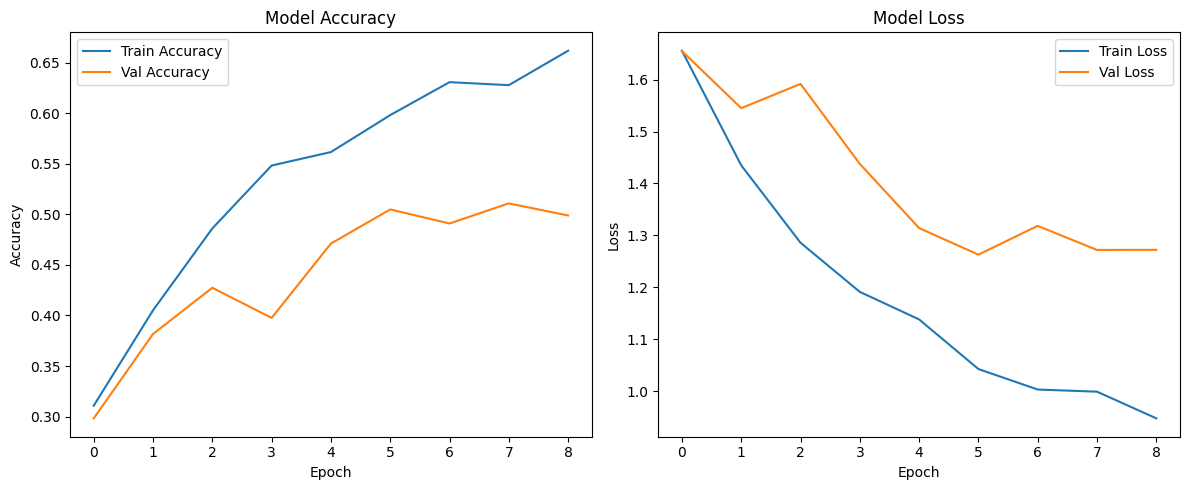

In [26]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Confusion matrix and classification report
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 507ms/step - accuracy: 0.5770 - loss: 1.1575
Validation Accuracy: 51.29%
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.66      0.50      0.57        80
       glass       0.43      0.70      0.53       100
       metal       0.51      0.46      0.48        82
       paper       0.51      0.77      0.61       118
     plastic       0.70      0.17      0.27        96
       trash       0.50      0.04      0.07        27

    accuracy                           0.51       503
   macro avg       0.55      0.44      0.42       503
weighted avg       0.55      0.51      0.47       503

Confusion Matrix:

[[40 16 15  7  2  0]
 [ 9 70  2 17  2  0]
 [ 5 18 38 19  2  0]
 [ 1 15 10 91  1  0]
 [ 4 30  7 38 16  1]
 [ 2 13  3  8  0  1]]


In [28]:
# --- Real-time Prediction Function ---
def predict_image(image_path, model_path="best_garbage_classifier.h5"):
    model = load_model(model_path)
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.0
    prediction = model.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    print(f"Predicted class: {predicted_class}")
    return predicted_class

# Example usage:
# predict_image("path/to/test_image.jpg")

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import gradio as gr

# Parameters
img_height, img_width = 150, 150
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']  # Replace with actual labels if different

# Load the best model
model = load_model("best_garbage_classifier.h5")

# Prediction function
def predict_image_gradio(image):
    image = image.resize((img_height, img_width))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.0
    prediction = model.predict(image)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = float(np.max(prediction))
    return {predicted_class: confidence}

# Gradio Interface
interface = gr.Interface(
    fn=predict_image_gradio,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    description="Upload an image of garbage and the model will classify it into the appropriate category."
)

# Launch the app
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22752644d8175ae394.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
